In [85]:
import numpy as np
import pandas as pd
import time
import string
import re
import math

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error as mse


import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
#!pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.io import curdoc, show, output_notebook
output_notebook()

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import pos_tag
stop_words = stopwords.words('english')

import spacy
#nlp = spacy.load('en_core_web_lg')
from spacy import displacy
#pip install transformers
import transformers

from transformers import BertTokenizer, TFBertModel, RobertaTokenizer, TFRobertaModel




In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train['excerpt_len'] = df_train['excerpt'].apply(
    lambda x : len(x)
)
df_train['excerpt_word_count'] = df_train['excerpt'].apply(
    lambda x : len(x.split(' '))
)

In [7]:
def removeStopwords(text):
    doc = nlp(text)
    clean_text = ' '
    for txt in doc:
        if (txt.is_stop == False):
            clean_text = clean_text + " " + str(txt)        
    
    return clean_text

In [8]:
def removePunctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [9]:
def removeLinks(text):
    clean_text = re.sub('https?://\S+|www\.\S+', '', text)
    #https? will match both http and https
    #A|B, where A and B can be arbitrary REs, creates a regular expression that will match either A or B.
    #\S Matches any character which is not a whitespace character.
    #+ Causes the resulting RE to match 1 or more repetitions of the preceding RE. ab+ will match ‘a’ followed by any non-zero number of ‘b’s; it will not match just ‘a’.
    return clean_text

In [10]:
def removeNumbers(text):
    clean_text = re.sub(r'\d+', '', text)
    return clean_text

In [11]:
def clean(text):
    text = text.lower() #Lets make it lowercase
    text = removeStopwords(text)
    text = removePunctuations(text)
    text = removeNumbers(text)
    text = removeLinks(text)
    return text

In [12]:
df_train['excerpt_clean'] = df_train['excerpt'].apply(clean)
df_test['excerpt_clean'] = df_test['excerpt'].apply(clean)

In [13]:
stemmer = SnowballStemmer(language='english')

tokens = df_train['excerpt'][1].split()
clean_text = ' '

In [14]:
def stemWord(text):
    stemmer = SnowballStemmer(language='english')
    tokens = text.split()
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + stemmer.stem(token)      
    
    return clean_text

In [15]:
df_train['excerpt_clean'] = df_train['excerpt_clean'].apply(stemWord)
df_test['excerpt_clean'] = df_test['excerpt_clean'].apply(stemWord)

In [16]:
def lemmatizeWord(text):
    tokens=nlp(text)
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + token.lemma_      
    
    return clean_text

In [17]:
rmse = lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred))
rmse_loss = lambda Estimator, X, y: rmse(y, Estimator.predict(X))

In [18]:
# Split into train and test sets


x = df_train['excerpt_clean']
y = df_train['target']

print(len(x), len(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

2834 2834


In [19]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),#unigram only
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    df_train['excerpt_clean'], 
    df_train['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for CountVectorizer(1,1): {val_score}')

Train Score for CountVectorizer(1,1): 0.9259460212919036


In [20]:
model = make_pipeline(
    CountVectorizer(ngram_range=(2,2)),#bigram only
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    df_train['excerpt_clean'], 
    df_train['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for CountVectorizer(2,2): {val_score}')

Train Score for CountVectorizer(2,2): 0.9870700155125688


In [21]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,2)),#unigram and bigrams
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    df_train['excerpt_clean'], 
    df_train['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for CountVectorizer(1,2): {val_score}')

Train Score for CountVectorizer(1,2): 0.8059500096790234


In [22]:
model = make_pipeline(
    CountVectorizer(ngram_range=(1,3)),#Unigrams + Bi-grams + Tri-grams
    LinearRegression(),
)

val_score = cross_val_score(
    model, 
    df_train['excerpt_clean'], 
    df_train['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for CountVectorizer(1,3): {val_score}')

Train Score for CountVectorizer(1,3): 0.8007469454152325


In [23]:
#Ridge_Regression
model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    Ridge(),
)

val_score = cross_val_score(
    model, 
    df_train['excerpt_clean'], 
    df_train['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for Ridge Regression: {val_score}')

Train Score for Ridge Regression: 0.9167814642279296


In [24]:
#Extreme Gradient Boosting
model = make_pipeline(
    CountVectorizer(ngram_range=(1,1)),
    xgb.XGBRegressor() ,
)

val_score = cross_val_score(
    model, 
    df_train['excerpt_clean'], 
    df_train['target'], 
    scoring=rmse_loss
).mean()

print(f'Train Score for Extreme Gradient Boosting: {val_score}')

[13:55:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Score for Extreme Gradient Boosting: 0.8923204941533942


In [25]:
#TD-IDF
def training(model, X_train, y_train, X_test, y_test, model_name, ngram_range):
    t1 = time.time()
    
    model = make_pipeline(
        TfidfVectorizer(binary=True, ngram_range=ngram_range),
        model,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mse(y_test, y_pred)
    
    t2 = time.time()
    training_time = t2-t1 
    
    print("--- Model:", model_name,"---")
    print("MSE: ",MSE)
    print("Training time:",training_time)
    print("\n")

In [29]:
ridge = Ridge(fit_intercept = True, normalize = False)
lr = LinearRegression()
xgbr = xgb.XGBRegressor()
lasso = Lasso(alpha=0.1)
hr = HuberRegressor(max_iter = 300)
models = [ridge,lr,xgbr,lasso,hr]

modelnames = ["Ridge Regression","Linear Regression","Extreme Gradient Boosting", "Lasso Regression","Tweedie Regressor","Huber Regressor"]

In [30]:
X = df_train["excerpt_clean"]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

n_gram_dict = { "Unigram" : (1,1), "Unigrams + Bigrams": (1,2), "Bigrams alone": (2,2), "Unigrams + Bigrams + Trigrams": (1,3)}

for n_gram in n_gram_dict.keys():
    print("\033[1m " + n_gram + " \n \033[0m")
    for i in range(0,len(models)):
        training(model=models[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=modelnames[i],ngram_range=n_gram_dict[n_gram])
    print("*" * 40)

 Unigram 
 
--- Model: Ridge Regression ---
MSE:  0.5407258653311647
Training time: 0.3176107406616211


--- Model: Linear Regression ---
MSE:  0.621813893389428
Training time: 0.33685970306396484


[14:01:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- Model: Extreme Gradient Boosting ---
MSE:  0.6909057311435994
Training time: 3.0572779178619385


--- Model: Lasso Regression ---
MSE:  1.0813873356865098
Training time: 0.35517263412475586




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


--- Model: Tweedie Regressor ---
MSE:  0.6144128775091242
Training time: 3.3459632396698


****************************************
 Unigrams + Bigrams 
 
--- Model: Ridge Regression ---
MSE:  0.5748399358343904
Training time: 1.0788676738739014


--- Model: Linear Regression ---
MSE:  0.5822784170965322
Training time: 1.18141508102417


[14:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- Model: Extreme Gradient Boosting ---
MSE:  0.9074474061034213
Training time: 16.26211404800415


--- Model: Lasso Regression ---
MSE:  1.0813873356865098
Training time: 1.670393943786621




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


--- Model: Tweedie Regressor ---
MSE:  0.5815467321424276
Training time: 21.280524253845215


****************************************
 Bigrams alone 
 
--- Model: Ridge Regression ---
MSE:  0.921455706202811
Training time: 0.8406388759613037


--- Model: Linear Regression ---
MSE:  0.8292816149898004
Training time: 0.8882155418395996


[14:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- Model: Extreme Gradient Boosting ---
MSE:  1.0181520918784115
Training time: 13.264244794845581


--- Model: Lasso Regression ---
MSE:  1.0813873356865098
Training time: 1.3544888496398926




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


--- Model: Tweedie Regressor ---
MSE:  0.8299077057868437
Training time: 18.908102989196777


****************************************
 Unigrams + Bigrams + Trigrams 
 
--- Model: Ridge Regression ---
MSE:  0.6001715478965208
Training time: 1.9212071895599365


--- Model: Linear Regression ---
MSE:  0.6268210990800221
Training time: 2.0422322750091553


[14:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- Model: Extreme Gradient Boosting ---
MSE:  0.8686109449003954
Training time: 30.557175636291504


--- Model: Lasso Regression ---
MSE:  1.0813873356865098
Training time: 3.075375556945801




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


--- Model: Tweedie Regressor ---
MSE:  0.6264647251277394
Training time: 41.0884313583374


****************************************


In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_root_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
                                            
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,)


In [34]:
vocab_size = 51038
embedding_dim = 64
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1)
])
#model.compile(loss='binary_crossentropy',optimizer='adam',)#metrics=[rmse])
model.compile(loss='mean_squared_error', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 64)            3266432   
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 3,266,497
Trainable params: 3,266,497
Non-trainable params: 0
_________________________________________________________________


In [37]:
text = df_train.excerpt_clean
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(text)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)

#validation_sequences = tokenizer.texts_to_sequences(text[800:])
#validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(df_train.target)
print(training_padded.shape)
print(training_labels_final.shape)

(2834, 50)
(2834,)


In [38]:
num_epochs = 35
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/35
80/80 [==============================] - 3s 20ms/step - loss: 1.5906 - root_mean_squared_error: 1.2612 - val_loss: 1.3815 - val_root_mean_squared_error: 1.1754
Epoch 2/35
80/80 [==============================] - 1s 17ms/step - loss: 1.0701 - root_mean_squared_error: 1.0344 - val_loss: 1.0467 - val_root_mean_squared_error: 1.0231
Epoch 3/35
80/80 [==============================] - 1s 17ms/step - loss: 0.7988 - root_mean_squared_error: 0.8937 - val_loss: 0.8617 - val_root_mean_squared_error: 0.9283
Epoch 4/35
80/80 [==============================] - 1s 17ms/step - loss: 0.6238 - root_mean_squared_error: 0.7898 - val_loss: 0.7573 - val_root_mean_squared_error: 0.8702
Epoch 5/35
80/80 [==============================] - 1s 17ms/step - loss: 0.5010 - root_mean_squared_error: 0.7078 - val_loss: 0.7088 - val_root_mean_squared_error: 0.8419
Epoch 6/35
80/80 [==============================] - 1s 16ms/step - loss: 0.4131 - root_mean_squared_error: 0.6427 - val_loss: 0.6937 - val_root_m

In [40]:
#Our model is over-fitting now. We need to optimize it.

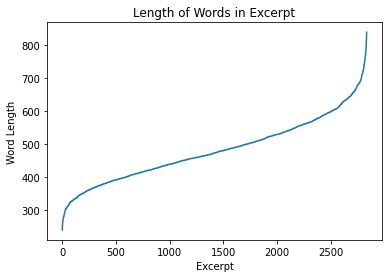

In [41]:
xs=[]
ys=[]
current_item=1
for item in text:
 xs.append(current_item)
 current_item=current_item+1
 ys.append(len(item))
newys = sorted(ys)
plt.xlabel('Excerpt')
plt.ylabel('Word Length')
plt.title('Length of Words in Excerpt')
plt.plot(xs,newys)

plt.show()

In [42]:
#Most excerpts have 800 words or less, so we use that value instead.
#We will create a simple model using an embedding after applying all the optimizations.

In [43]:
#Create the model using an Embedding
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error',optimizer='adam', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            3266432   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 3,268,017
Trainable params: 3,268,017
Non-trainable params: 0
_________________________________________________________________


In [44]:
num_epochs = 100
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
80/80 [==============================] - 4s 41ms/step - loss: 1.7763 - root_mean_squared_error: 1.2380 - val_loss: 1.3414 - val_root_mean_squared_error: 1.0733
Epoch 2/100
80/80 [==============================] - 3s 37ms/step - loss: 0.9801 - root_mean_squared_error: 0.9053 - val_loss: 0.9288 - val_root_mean_squared_error: 0.8858
Epoch 3/100
80/80 [==============================] - 3s 37ms/step - loss: 0.6462 - root_mean_squared_error: 0.7182 - val_loss: 0.7887 - val_root_mean_squared_error: 0.8178
Epoch 4/100
80/80 [==============================] - 3s 38ms/step - loss: 0.4524 - root_mean_squared_error: 0.5829 - val_loss: 0.7428 - val_root_mean_squared_error: 0.7969
Epoch 5/100
80/80 [==============================] - 3s 38ms/step - loss: 0.3290 - root_mean_squared_error: 0.4789 - val_loss: 0.7366 - val_root_mean_squared_error: 0.8010
Epoch 6/100
80/80 [==============================] - 3s 38ms/step - loss: 0.2498 - root_mean_squared_error: 0.3989 - val_loss: 0.7403 - val_

In [46]:
#Convolutional Neural Network (CNN/ConvNet)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(embedding_dim, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(), 
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            3266432   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 64)            20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 3,288,561
Trainable params: 3,288,561
Non-trainable params: 0
_________________________________________________________________


In [47]:
num_epochs = 100
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
80/80 [==============================] - 4s 46ms/step - loss: 2.1931 - root_mean_squared_error: 1.3644 - val_loss: 2.1149 - val_root_mean_squared_error: 1.3378
Epoch 2/100
80/80 [==============================] - 3s 43ms/step - loss: 1.8778 - root_mean_squared_error: 1.2485 - val_loss: 1.8717 - val_root_mean_squared_error: 1.2485
Epoch 3/100
80/80 [==============================] - 3s 43ms/step - loss: 1.6439 - root_mean_squared_error: 1.1562 - val_loss: 1.6931 - val_root_mean_squared_error: 1.1797
Epoch 4/100
80/80 [==============================] - 3s 42ms/step - loss: 1.4570 - root_mean_squared_error: 1.0776 - val_loss: 1.5594 - val_root_mean_squared_error: 1.1266
Epoch 5/100
80/80 [==============================] - 3s 43ms/step - loss: 1.3186 - root_mean_squared_error: 1.0167 - val_loss: 1.4722 - val_root_mean_squared_error: 1.0923
Epoch 6/100
80/80 [==============================] - 3s 43ms/step - loss: 1.2204 - root_mean_squared_error: 0.9732 - val_loss: 1.4154 - val_

In [48]:
#Gated Recurrent Units RNN(GRU)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 64)            3266432   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                18816     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 3,285,313
Trainable params: 3,285,313
Non-trainable params: 0
_________________________________________________________________


In [49]:
num_epochs = 35
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/35
80/80 [==============================] - 11s 85ms/step - loss: 1.9354 - root_mean_squared_error: 1.3912 - val_loss: 1.9729 - val_root_mean_squared_error: 1.4046
Epoch 2/35
80/80 [==============================] - 6s 74ms/step - loss: 1.8424 - root_mean_squared_error: 1.3574 - val_loss: 1.8833 - val_root_mean_squared_error: 1.3723
Epoch 3/35
80/80 [==============================] - 6s 75ms/step - loss: 1.7415 - root_mean_squared_error: 1.3196 - val_loss: 1.7836 - val_root_mean_squared_error: 1.3355
Epoch 4/35
80/80 [==============================] - 6s 74ms/step - loss: 1.6284 - root_mean_squared_error: 1.2761 - val_loss: 1.6733 - val_root_mean_squared_error: 1.2935
Epoch 5/35
80/80 [==============================] - 6s 74ms/step - loss: 1.5034 - root_mean_squared_error: 1.2261 - val_loss: 1.5520 - val_root_mean_squared_error: 1.2458
Epoch 6/35
80/80 [==============================] - 6s 74ms/step - loss: 1.3677 - root_mean_squared_error: 1.1695 - val_loss: 1.4260 - val_root_

In [50]:
#Bidirectional Long Short Term Memory (LSTM)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 64)            3266432   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,332,609
Trainable params: 3,332,609
Non-trainable params: 0
_________________________________________________________________


In [51]:
num_epochs = 35
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/35
80/80 [==============================] - 11s 98ms/step - loss: 1.9411 - root_mean_squared_error: 1.3932 - val_loss: 1.9779 - val_root_mean_squared_error: 1.4064
Epoch 2/35
80/80 [==============================] - 7s 87ms/step - loss: 1.8281 - root_mean_squared_error: 1.3521 - val_loss: 1.8206 - val_root_mean_squared_error: 1.3493
Epoch 3/35
80/80 [==============================] - 7s 86ms/step - loss: 1.4515 - root_mean_squared_error: 1.2048 - val_loss: 1.1810 - val_root_mean_squared_error: 1.0867
Epoch 4/35
80/80 [==============================] - 7s 90ms/step - loss: 0.9886 - root_mean_squared_error: 0.9943 - val_loss: 1.0960 - val_root_mean_squared_error: 1.0469
Epoch 5/35
80/80 [==============================] - 7s 88ms/step - loss: 0.8806 - root_mean_squared_error: 0.9384 - val_loss: 0.9970 - val_root_mean_squared_error: 0.9985
Epoch 6/35
80/80 [==============================] - 7s 89ms/step - loss: 0.7282 - root_mean_squared_error: 0.8534 - val_loss: 0.8777 - val_root_

In [52]:
#Multiple Bidirectional Long Short Term Memory (LSTM)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1)
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 64)            3266432   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 3,431,425
Trainable params: 3,431,425
Non-trainable params: 0
_________________________________________________________________


In [53]:
num_epochs = 35
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.1,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/35
80/80 [==============================] - 20s 165ms/step - loss: 1.9124 - root_mean_squared_error: 1.3829 - val_loss: 1.8910 - val_root_mean_squared_error: 1.3751
Epoch 2/35
80/80 [==============================] - 12s 149ms/step - loss: 1.5054 - root_mean_squared_error: 1.2270 - val_loss: 1.1932 - val_root_mean_squared_error: 1.0923
Epoch 3/35
80/80 [==============================] - 12s 146ms/step - loss: 1.0287 - root_mean_squared_error: 1.0143 - val_loss: 1.1258 - val_root_mean_squared_error: 1.0610
Epoch 4/35
80/80 [==============================] - 12s 148ms/step - loss: 0.9535 - root_mean_squared_error: 0.9765 - val_loss: 1.0483 - val_root_mean_squared_error: 1.0238
Epoch 5/35
80/80 [==============================] - 12s 148ms/step - loss: 0.8362 - root_mean_squared_error: 0.9144 - val_loss: 0.9121 - val_root_mean_squared_error: 0.9551
Epoch 6/35
80/80 [==============================] - 12s 148ms/step - loss: 0.6385 - root_mean_squared_error: 0.7991 - val_loss: 0.7727 

In [54]:
#Exploring Hyper Parameter Tuning with Keras
#Let's define a function to build our model. Try optimizing units and learning rate.
def model_builder(hp):
  model = keras.Sequential()
  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=16, max_value=256, step=8)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(),
                metrics=[RootMeanSquaredError()])

  return model

In [58]:
tuner_search=kt.RandomSearch(model_builder,
                       objective = kt.Objective("val_root_mean_squared_error", direction="min"),
                       max_trials=5,directory='output',project_name="nlp")

In [59]:
tuner_search.search(training_padded,training_labels_final,epochs=10,validation_split=0.1)

Trial 5 Complete [00h 00m 39s]
val_root_mean_squared_error: 1.0308570861816406

Best val_root_mean_squared_error So Far: 1.0225557088851929
Total elapsed time: 00h 02m 52s
INFO:tensorflow:Oracle triggered exit


In [60]:
#Hyperband
tuner = kt.Hyperband(model_builder,
                     max_epochs=10,
                     objective = kt.Objective("val_root_mean_squared_error", direction="min"),
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [61]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [62]:
tuner.search(training_padded, training_labels_final, epochs=5, validation_split=0.1, callbacks=[stop_early])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and the optimal learning rate for the optimizeris {best_hps.get('learning_rate')}.""")

Trial 30 Complete [00h 00m 23s]
val_root_mean_squared_error: 1.024280071258545

Best val_root_mean_squared_error So Far: 1.0225090980529785
Total elapsed time: 00h 08m 24s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 232 and the optimal learning rate for the optimizeris 0.001.


In [64]:
#Glove Embeddings
glove_embeddings = dict()
f = open('glove.6B.50d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 glove_embeddings[word] = coefs
f.close()

In [65]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(glove_embeddings[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(50)
    return v / np.sqrt((v ** 2).sum())

In [66]:
#Extreme Gradient Boosting Regressor
xtrain, xvalid, ytrain, yvalid = train_test_split(df_train.excerpt_clean, df_train.target, 
 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [69]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in xtrain]
xvalid_glove = [sent2vec(x) for x in xvalid]

In [70]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [71]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBRegressor(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict(xvalid_glove)

print ("MSE: %f " % mse(yvalid, predictions))

[14:53:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 0.619243 


In [72]:
#GloVe Stacked LSTM
embedding_dim = 50
vocab_size = 51308

In [73]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
 if index > vocab_size - 1:
     break
 else:
     embedding_vector = glove_embeddings.get(word)
 if embedding_vector is not None:
     embedding_matrix[index] = embedding_vector

In [74]:
model = tf.keras.Sequential([
 tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
 return_sequences=True)),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
 tf.keras.layers.Dense(24, activation='relu'),
 tf.keras.layers.Dense(1)
])

In [75]:
learning_rate = 0.00003
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          2565400   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         40400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                2424      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 2,668,649
Trainable params: 103,249
Non-trainable params: 2,565,400
_________________________________________________________________


In [76]:
num_epochs = 100
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_split=0.3,
                    #validation_data=(validation_padded, validation_labels_final),
                   callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/100
62/62 [==============================] - 15s 134ms/step - loss: 1.9518 - root_mean_squared_error: 1.3971 - val_loss: 1.3822 - val_root_mean_squared_error: 1.1757
Epoch 2/100
62/62 [==============================] - 6s 98ms/step - loss: 1.4963 - root_mean_squared_error: 1.2232 - val_loss: 1.0985 - val_root_mean_squared_error: 1.0481
Epoch 3/100
62/62 [==============================] - 6s 97ms/step - loss: 1.2681 - root_mean_squared_error: 1.1261 - val_loss: 1.0216 - val_root_mean_squared_error: 1.0108
Epoch 4/100
62/62 [==============================] - 6s 96ms/step - loss: 1.1761 - root_mean_squared_error: 1.0845 - val_loss: 0.9721 - val_root_mean_squared_error: 0.9859
Epoch 5/100
62/62 [==============================] - 6s 99ms/step - loss: 1.1006 - root_mean_squared_error: 1.0491 - val_loss: 0.9124 - val_root_mean_squared_error: 0.9552
Epoch 6/100
62/62 [==============================] - 6s 97ms/step - loss: 1.0172 - root_mean_squared_error: 1.0086 - val_loss: 0.8484 - va

In [77]:
#HuggingFace TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [78]:
def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.excerpt)):
      encoded = tokenizer.encode_plus(
        
        data.excerpt[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [79]:
train_input_ids,train_attention_masks = bert_encode(df_train,60)
test_input_ids,test_attention_masks = bert_encode(df_test,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [80]:
def create_model(bert_model):
  input_ids = tf.keras.Input(shape=(60,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
  output = bert_model([input_ids,attention_masks])
  output = output[1]
  #output = tf.keras.layers.Dense(32,activation='relu')(output)
  #output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(1)(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(tf.keras.optimizers.Adam(lr=6e-6), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
  return model

In [81]:
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [82]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            1025        tf_bert_model[0][1]          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [83]:
history = model.fit([train_input_ids,train_attention_masks],df_train.target,validation_split=0.3, epochs=2,batch_size=10)

Epoch 1/2
199/199 [==============================] - 4836s 24s/step - loss: 0.6661 - root_mean_squared_error: 0.8161 - val_loss: 0.4862 - val_root_mean_squared_error: 0.6973
Epoch 2/2
199/199 [==============================] - 4800s 24s/step - loss: 0.3665 - root_mean_squared_error: 0.6054 - val_loss: 0.4941 - val_root_mean_squared_error: 0.7029


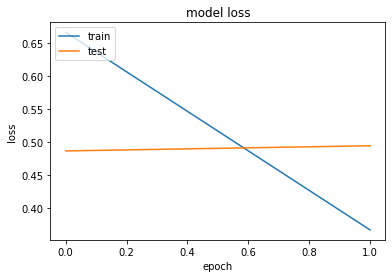

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
#roberta-base Hugging Face Transformer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
BASE_MODEL = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [89]:
def create_model(bert_model):
  input_ids = tf.keras.Input(shape=(60,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
  output = bert_model([input_ids,attention_masks])
  output = output[1]
  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(1)(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  
  return model
model = create_model(BASE_MODEL)
model.compile(tf.keras.optimizers.Adam(lr=6e-6), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 32)           24608       tf_roberta_model[0][1]     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [90]:
history = model.fit([train_input_ids,train_attention_masks],df_train.target,validation_split=0.3, epochs=2,batch_size=10)

Epoch 1/2
199/199 [==============================] - 1428s 7s/step - loss: 1.1264 - root_mean_squared_error: 1.0613 - val_loss: 0.7846 - val_root_mean_squared_error: 0.8858
Epoch 2/2
199/199 [==============================] - 1398s 7s/step - loss: 0.9577 - root_mean_squared_error: 0.9786 - val_loss: 0.7611 - val_root_mean_squared_error: 0.8724
